In [1]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam
from flax.optim.sgd import GradientDescent
import tqdm

ROS is not sourced. To enable ROS features, please source it


# Load SLAM data

In [2]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
# datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [3]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [4]:
laser_data_list = []
with open(datafile, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        laser_data_list.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

In [5]:
def plot_laser_data_points(laser_data_list, indeces, c=None, s=0.3):
    all_points = []
    for i in range(len(indeces)):
        laser_data = laser_data_list[indeces[i]]
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=s, c=c)

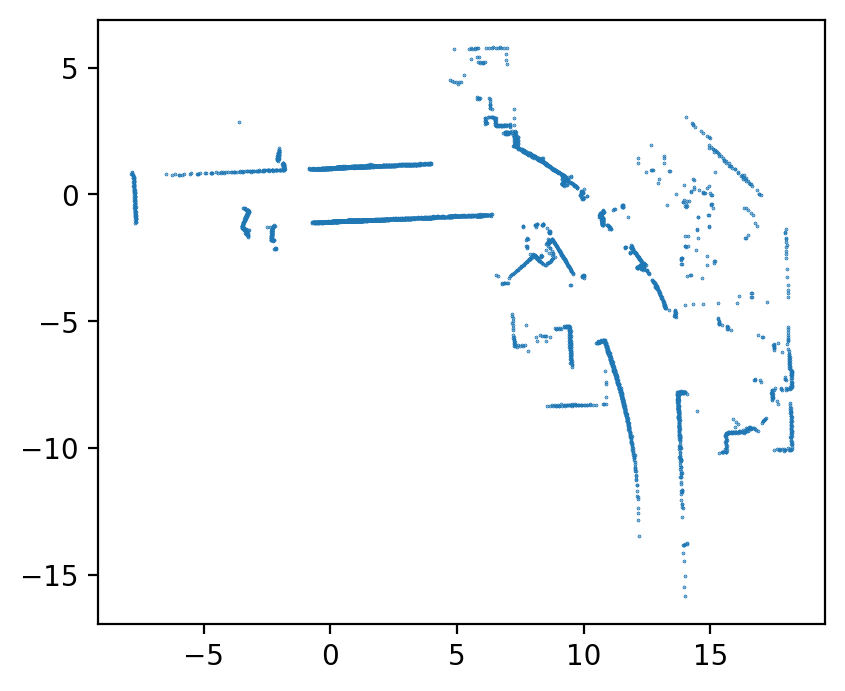

In [6]:
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

# Rendering

In [7]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256, use_bias=True)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [8]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(100, 100)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], 100), 
                                  jnp.linspace(bounds[2], bounds[3], 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [9]:
model = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
output = model.apply(variables, batch)

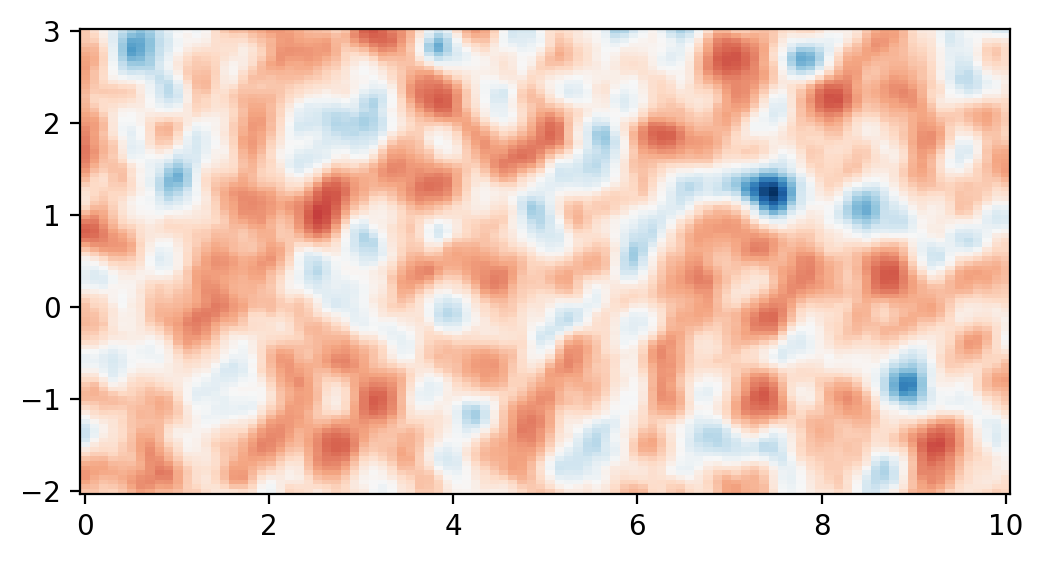

In [10]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (0, 10, -2, 3))

In [11]:
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    variance_weight: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [12]:
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(uniform, parameters):
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, x, y, angle):
    x = x[..., None]
    y = y[..., None]
    angle = angle[..., None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, angles, angle_deltas):
    x = depths * jnp.cos(angles[..., None] + angle_deltas)
    y = depths * jnp.sin(angles[..., None] + angle_deltas)
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=6)
def loss_function(variables, position, truth_depths, angles, uniform, angle_deltas, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles, angle_deltas)
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return jnp.mean((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-4) +
                   config.variance_weight * predicted_variance)

In [13]:
@functools.partial(jax.jit, static_argnums=4)
def predict_depths(variables, position, angles, uniform, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles, jnp.zeros((angles.shape[0], config.bins_count + 1)))
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    return predicted_depths

In [14]:
@functools.partial(jax.jit, static_argnums=4)
def predict_normalized_depths(variables, position, angles, uniform, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles)
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return predicted_depths / jnp.sqrt(jax.lax.stop_gradient(predicted_variance + 1e-2))

## Test loss

In [15]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=0.5,
    variance_weight=0.1
)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
n = 30
position = jnp.ones(3)
angle_deltas = jnp.ones([n, config.bins_count + 1])
loss = loss_function(
    variables, 
    truth_depths=jnp.ones(n), 
    angles=jnp.ones(n), 
    uniform=jnp.ones([n, config.bins_count]),
    position=position,
    angle_deltas=angle_deltas,
    config=config)
print(loss)
grad_function = jax.grad(loss_function)
grad = grad_function( 
    variables, 
    truth_depths=jnp.ones(n), 
    angles=jnp.ones(n), 
    uniform=jnp.ones([n, config.bins_count]),
    position=position,
    angle_deltas=angle_deltas,
    config=config)

1.9009665


In [16]:
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
position = jnp.array(laser_data.odometry_position.as_vec())
angle_deltas = jax.random.normal(jax.random.PRNGKey(0), (angles.shape[0], config.bins_count + 1)) * 0.03
loss_function(variables, position, depths, angles, uniform, angle_deltas, config)

DeviceArray(1.7458202, dtype=float32)

# Run on one scan

In [17]:
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
position = jnp.array(laser_data.odometry_position.as_vec())
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
grad_function = jax.grad(loss_function)
optimizer = Adam(5e-3, beta1=0.9, beta2=0.999)
state = optimizer.init_state(variables)
losses = []
for i in range(iterations):
    rotated_position = position
    angle_deltas = jax.random.normal(jax.random.PRNGKey(i), (angles.shape[0], config.bins_count + 1)) * 0
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = grad_function(variables, rotated_position, depths, angles, uniform, angle_deltas, config)
    loss = loss_function(variables, rotated_position, depths, angles, uniform, angle_deltas, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(0.01370427, dtype=float32)

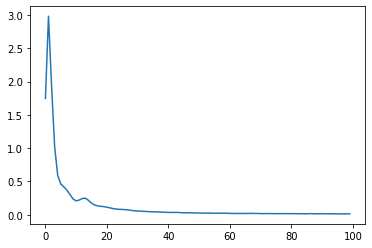

In [18]:
plt.plot(losses)

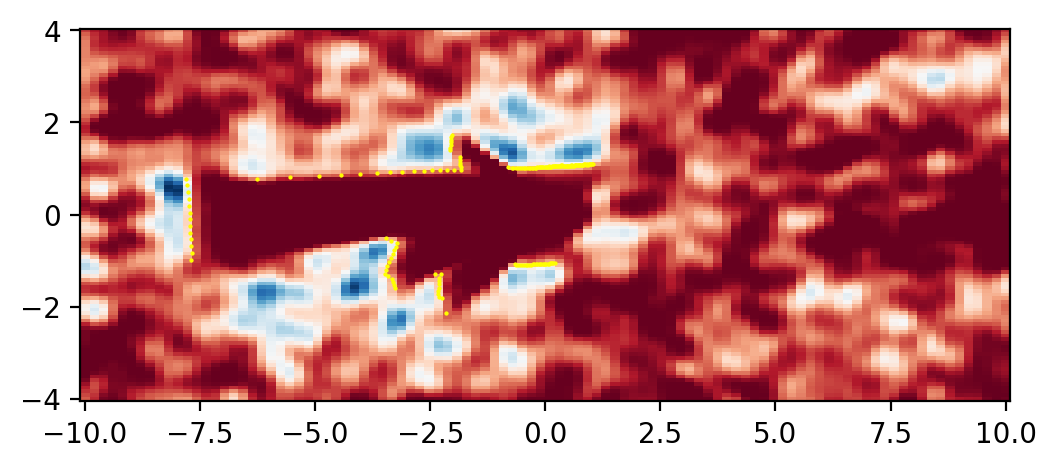

In [19]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (-10, 10, -4, 4))
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")
plt.gca().set_aspect('equal')

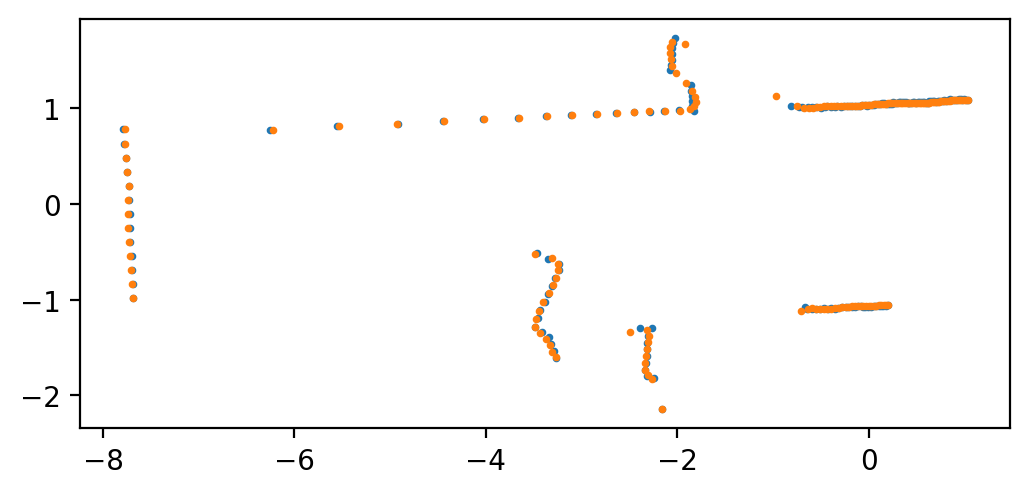

In [20]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plt.gca().set_aspect('equal')

# Optimize position

In [21]:
position_grad_function = jax.grad(loss_function, argnums=1)

In [22]:
iterations = 200
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))

# position = jnp.array(laser_data.odometry_position.as_vec())
# optimized_position = jnp.array([1.3, 0.08, 2.77])
# optimized_position = jnp.array([0.6, 0.08, 1.3])
# optimized_position = jnp.array([0.6, 1., 2.77])
optimized_position = jnp.array([-3, 1., 2.77])

optimizer = Adam(6e-1, beta1=0.8, beta2=0.999)
# optimizer = GradientDescent(2e-3)
state = optimizer.init_state(optimized_position)
losses = []
position_history = [Position2.from_vec(np.array(optimized_position))]
for i in range(iterations):
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    angle_deltas = jax.random.normal(jax.random.PRNGKey(i), (angles.shape[0], config.bins_count + 1)) * 0
    grad = position_grad_function(variables, optimized_position, depths, angles, uniform, angle_deltas, config)
    loss = loss_function(variables, optimized_position, depths, angles, uniform, angle_deltas, config)
    losses.append(loss)
    optimized_position, state = optimizer.apply_gradient(optimizer.hyper_params, optimized_position, state, grad)
    position_history.append(Position2.from_vec(np.array(optimized_position)))
print(losses[-1])
print(optimized_position)
print(laser_data.odometry_position.as_vec())

13.663074
[0.5985947  0.09820348 2.7602572 ]
[0.656165  0.0812728 2.77968  ]


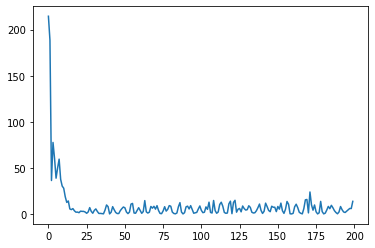

In [23]:
plt.plot(losses)

In [24]:
def plot_positions(position_history):
    positions = Position2.from_array(position_history).as_vec()
    plt.plot(positions[:, 0], positions[:, 1])
    plt.quiver(positions[:, 0], positions[:, 1], np.cos(positions[:, 2]), np.sin(positions[:, 2]), scale=25)
    
def plot_position(positions):
    plt.quiver(positions[None, 0], positions[None, 1], np.cos(positions[None, 2]), 
               np.sin(positions[None, 2]), scale=10, color="red")

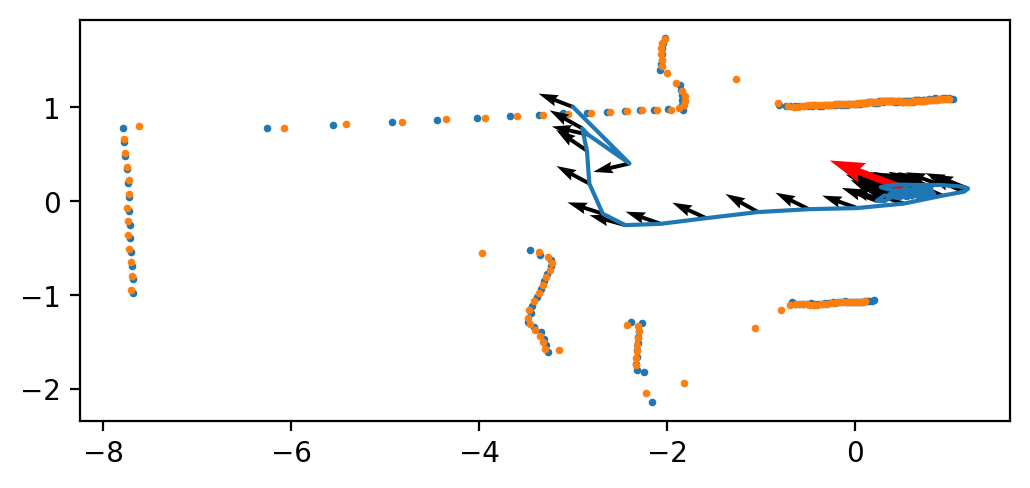

In [25]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = Position2.from_vec(np.array(optimized_position)).apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plot_positions(position_history)
plot_position(laser_data.odometry_position.as_vec())
plt.gca().set_aspect('equal')

## Hessian

In [26]:
def huber(input_array, delta):
    mask = jnp.abs(input_array) < delta
    result = jnp.where(mask, input_array ** 2, delta * (2 * jnp.abs(input_array) - delta))
    return jnp.sum(result)

In [27]:
@functools.partial(jax.jit, static_argnums=5)
def loss_function_without_normalization(variables, position, truth_depths, angles, uniform, config):
    predicted_depths0 = predict_depths(variables, position, angles, uniform, config)
    return jnp.sum(((truth_depths - predicted_depths0) ** 2))
#     return huber(truth_depths - predicted_depths, 0.3)

In [52]:
partial_predict_depths = functools.partial(predict_depths, config=config)
jacobian_function = jax.jacfwd(partial_predict_depths, argnums=1)
position_grad_function = jax.grad(functools.partial(loss_function_without_normalization, config=config), argnums=1)
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))

# position = jnp.array(laser_data.odometry_position.as_vec())
# optimized_position = jnp.array([-3, 1., 2.77])
optimized_position = jnp.array([0.6, 0.08, 3.4])
# optimized_position = jnp.array([0.656, 0.0812, 2.3])
# optimized_position = jnp.array([0.6, 0.08, -2])
# optimized_position = jnp.array([0, -1, 2.7])
# optimized_position = jnp.array(laser_data_list[7].odometry_position.as_vec())
# optimized_position = jnp.array(laser_data_list[3].odometry_position.as_vec())
# optimized_position = jnp.array([-3, 1., 2.77])
print(optimized_position)

losses = []
position_history = [Position2.from_vec(np.array(optimized_position))]
for i in range(iterations):
    grad = position_grad_function(variables, optimized_position, depths, angles, uniform)
    jacobian = jacobian_function(variables, optimized_position, angles, uniform)
    hessian = 2 * jacobian.T @ jacobian  + jnp.diag(jnp.array([20, 20, 200]))
    delta = -jnp.linalg.inv(hessian) @ grad
    optimized_position = optimized_position + delta
    loss = loss_function_without_normalization(variables, optimized_position, depths, angles, uniform, config)
    losses.append(loss)
    position_history.append(Position2.from_vec(np.array(optimized_position)))
print(losses[-1])
print(optimized_position)
print(laser_data.odometry_position.as_vec())
print(hessian)
print(grad)
print(delta)

[0.6  0.08 3.4 ]
540.83105
[-0.3543346   0.93245107  3.4690986 ]
[0.656165  0.0812728 2.77968  ]
[[   738.3038     -88.55892   1321.8318 ]
 [   -88.55892  36774.402   -11750.623  ]
 [  1321.8318  -11750.623    22915.611  ]]
[ 162.26459 -252.91748  382.48032]
[-0.21711423  0.00600749 -0.0010866 ]


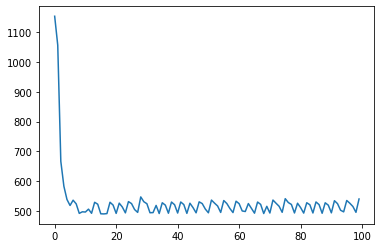

In [53]:
plt.plot(losses)

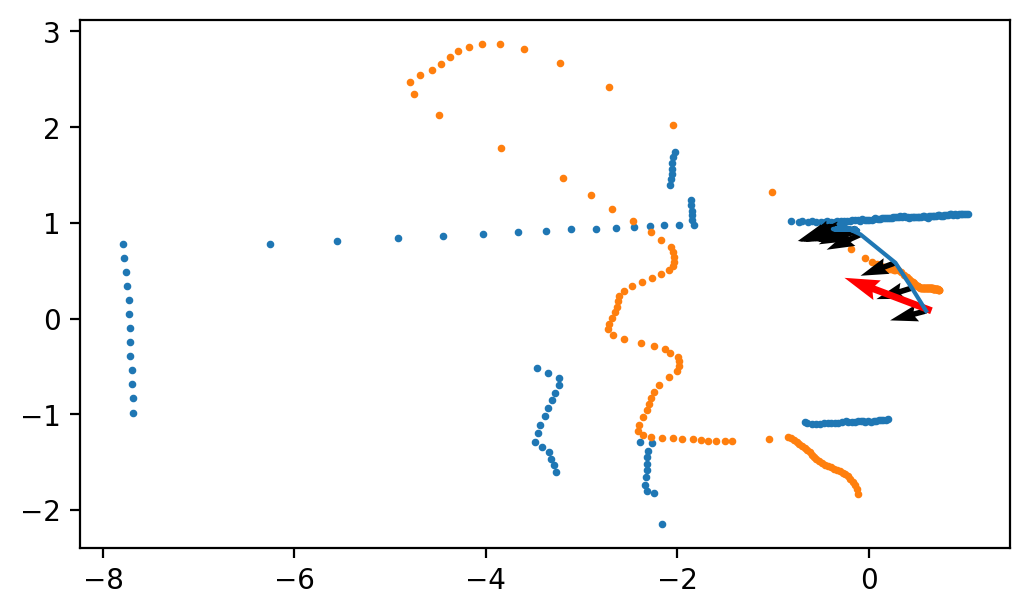

In [54]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
# new_points = Position2.from_vec(np.array(optimized_position)).apply(new_points)
new_points = laser_data.odometry_position.apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plot_positions(position_history)
plot_position(laser_data.odometry_position.as_vec())
plt.gca().set_aspect('equal')

# Loss function for rotation

In [56]:
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
losses = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    loss = loss_function_without_normalization(variables, rotated_position, depths, angles, uniform, config)
    losses.append(loss)

Text(0.5, 1.0, 'Loss function from angle')

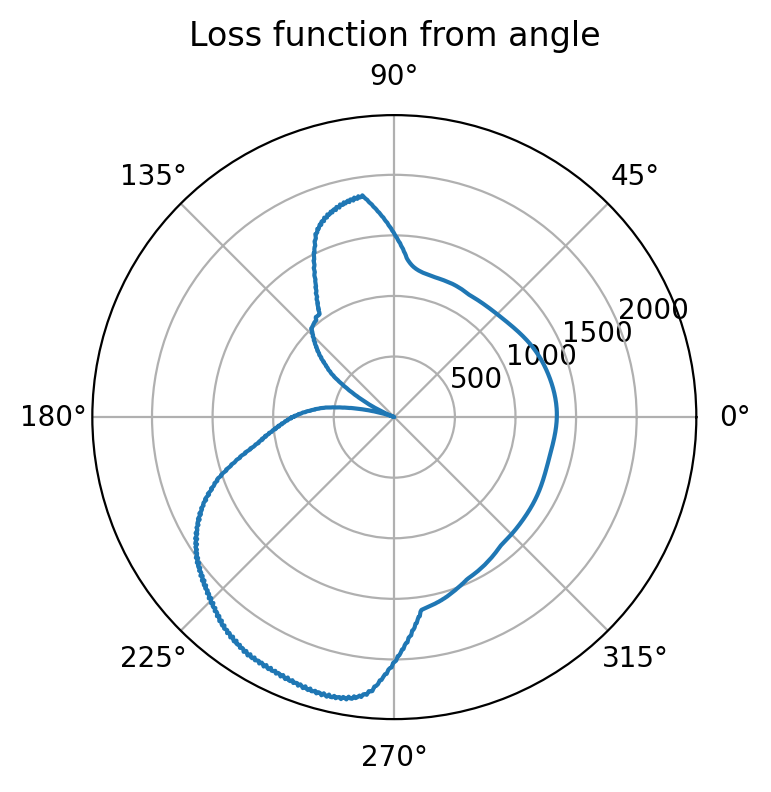

In [58]:
plt.figure(dpi=200)
plt.polar(position_angles, losses)
plt.title("Loss function from angle")

Text(0, 0.5, 'Loss')

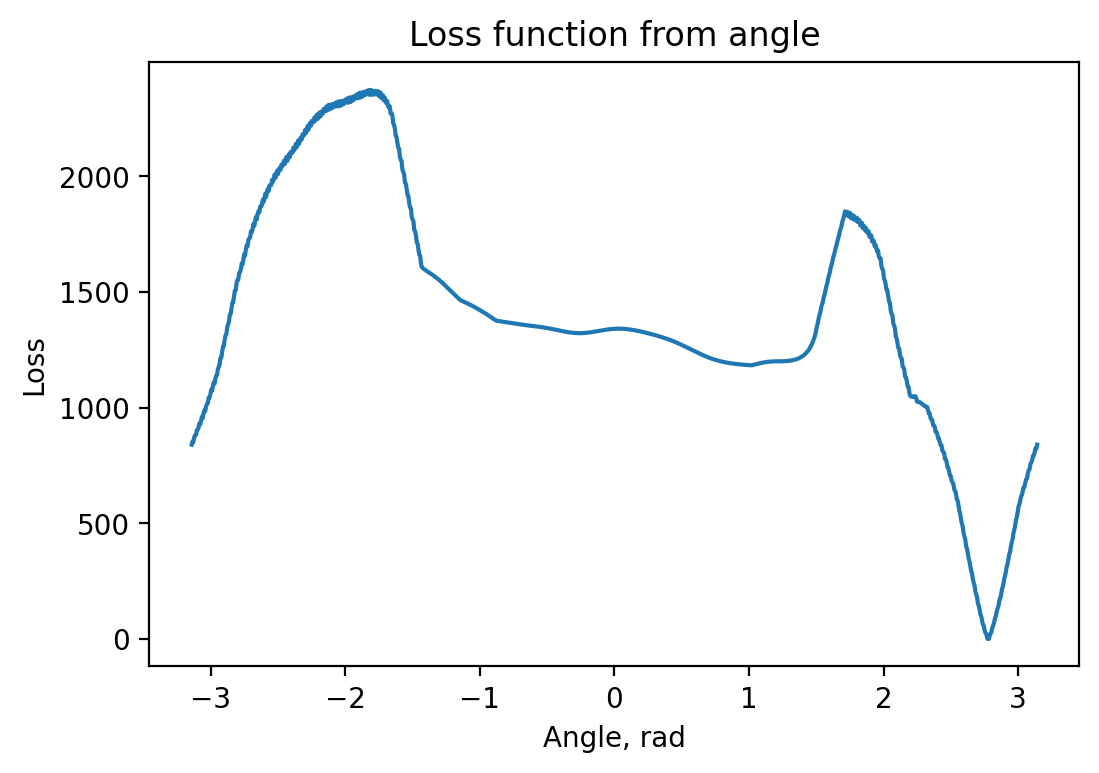

In [62]:
plt.figure(dpi=200)
plt.plot(position_angles, losses)
plt.title("Loss function from angle")
plt.xlabel("Angle, rad")
plt.ylabel("Loss")

In [75]:
position_grad_function = jax.grad(functools.partial(loss_function_without_normalization, config=config), argnums=1)
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
grads = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    angle_deltas = jax.random.normal(jax.random.PRNGKey(0), (angles.shape[0],)) * 0.03
    grad = position_grad_function(variables, rotated_position, depths, angles, uniform)
    grads.append(grad[2])

Text(0.5, 0, 'angle, rad')

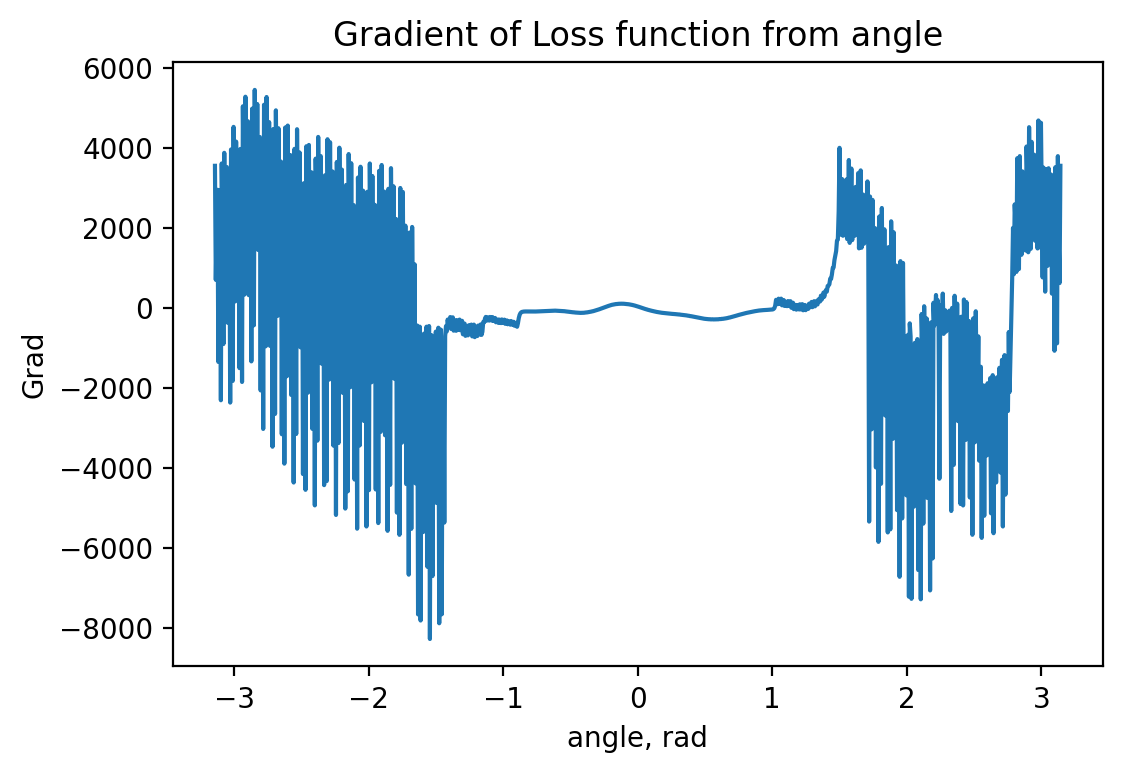

In [76]:
plt.figure(dpi=200)
plt.plot(position_angles, grads)
plt.title("Gradient of Loss function from angle")
plt.ylabel("Grad")
plt.xlabel("angle, rad")

In [65]:
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
predict_depths(variables, position, angles, uniform, config)
predicted_depths = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    depth = predict_depths(variables, rotated_position, angles, uniform, config)
    predicted_depths.append(depth[0])

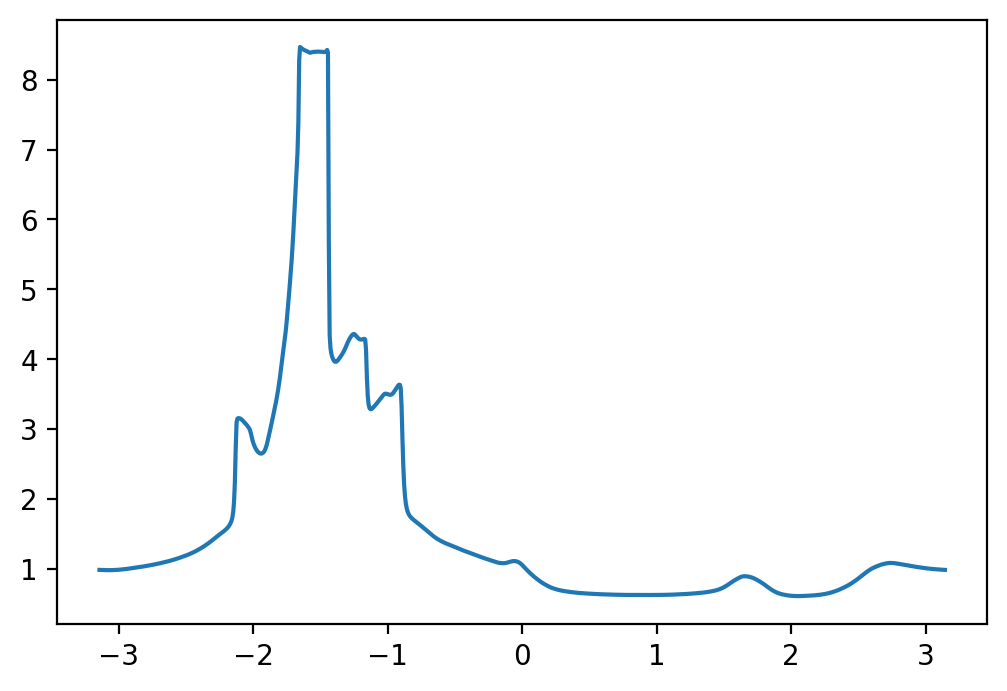

In [66]:
plt.figure(dpi=200)
plt.plot(position_angles, predicted_depths)

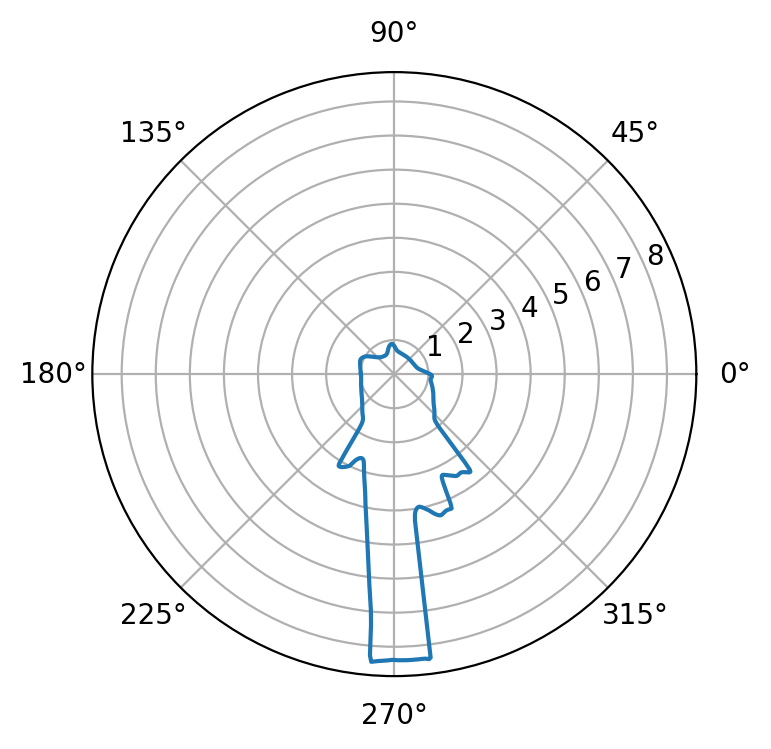

In [67]:
plt.figure(dpi=200)
plt.polar(position_angles, predicted_depths)

In [68]:
def depth_sum(variables, rotated_position, angles, uniform, config):
    return jnp.sum(predict_depths(variables, rotated_position, angles, uniform, config)[0])

depth_grad_function = jax.grad(functools.partial(depth_sum, config=config), argnums=1)
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
grads = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    grad = depth_grad_function(variables, rotated_position, angles, uniform)
    grads.append(grad[2])

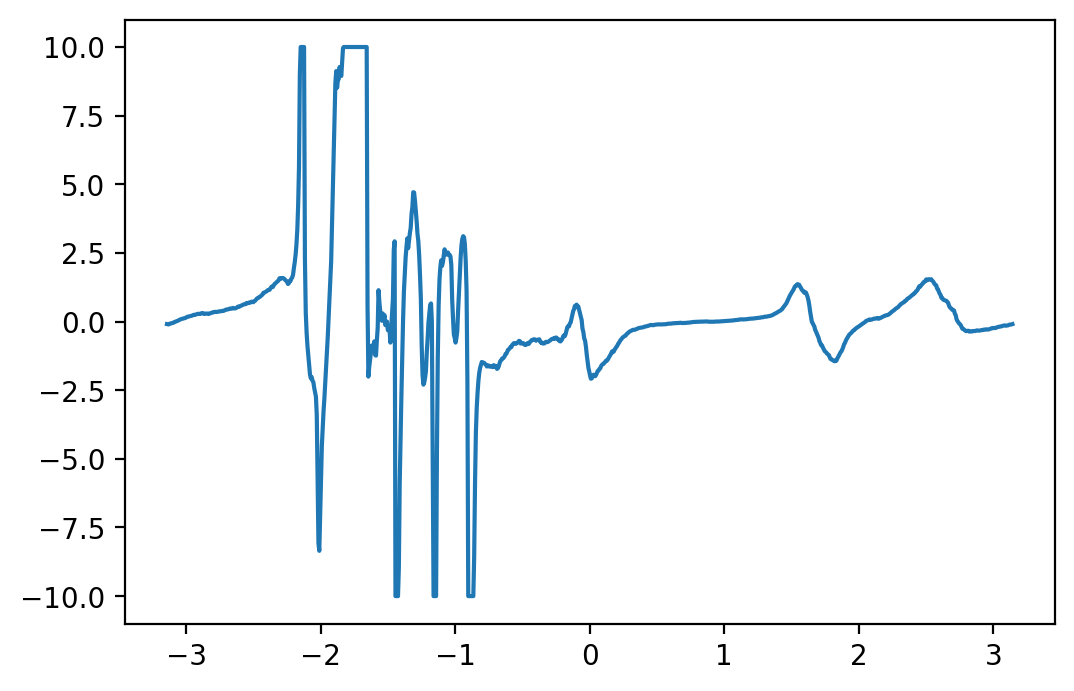

In [69]:
plt.figure(dpi=200)
plt.plot(position_angles, jnp.clip(jnp.array(grads), -10, 10))

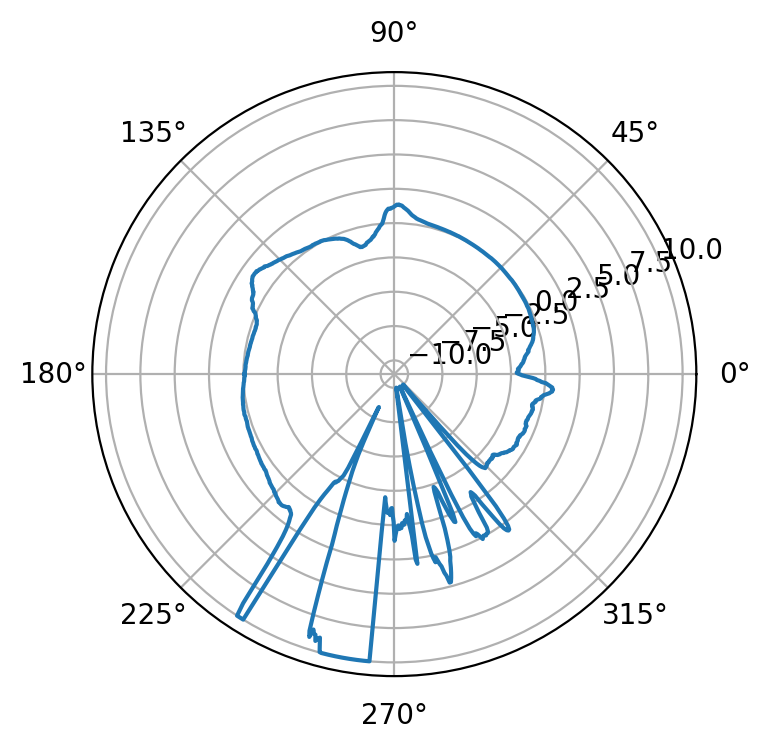

In [70]:
plt.figure(dpi=200)
plt.polar(position_angles, jnp.clip(jnp.array(grads), -10, 10))


In [71]:
depth_jacobian_function = jax.jacfwd(functools.partial(predict_depths, config=config), argnums=1)

@functools.partial(jax.jit, static_argnums=5)
def loss_clip_grads(variables, position, truth_depths, angles, uniform, config):
    predicted_depths = predict_depths(variables, position, angles, uniform, config)
    jacobian = depth_jacobian_function(variables, position, angles, uniform)
    grad_threshold = 40
    clip_grads = jnp.clip(jacobian, -grad_threshold, grad_threshold)
    clip_grads = jnp.stack([jacobian[:, 0], jacobian[:, 1], clip_grads[:, 2]], axis=1)
    return 2 * jnp.sum(clip_grads * (predicted_depths - truth_depths)[:, None], axis=0)

In [72]:
# position_angles = jnp.linspace(2, 3, 1000)
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
norm_grads = []
for angle in tqdm.tqdm(position_angles):
    rotated_position = jnp.array([position[0], position[1], angle])
    norm_grad = loss_clip_grads(variables, rotated_position, depths, angles, uniform, config)
    norm_grads.append(norm_grad[2])

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 158.08it/s]


Text(0, 0.5, 'Grad')

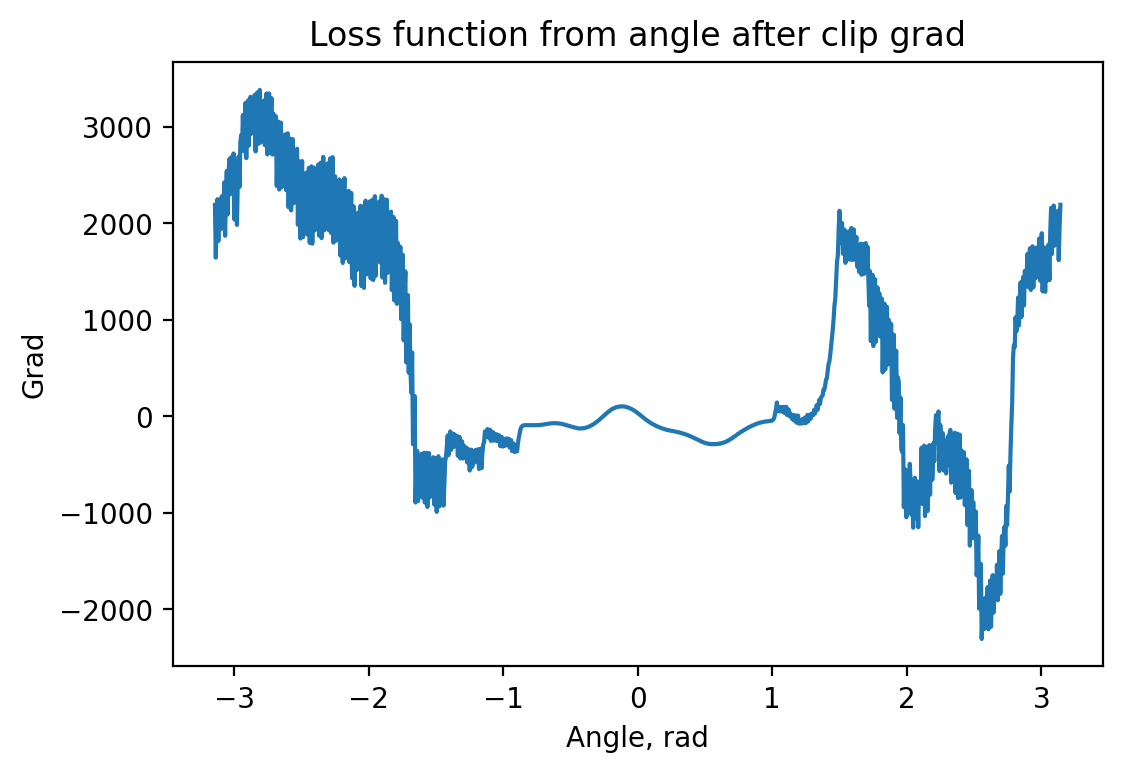

In [73]:
plt.figure(dpi=200)
# plt.plot(position_angles, grads)
plt.plot(position_angles, norm_grads)
plt.title("Loss function from angle after clip grad")
plt.xlabel("Angle, rad")
plt.ylabel("Grad")

In [262]:
partial_predict_depths = functools.partial(predict_depths, config=config)
jacobian_function = jax.jacfwd(partial_predict_depths, argnums=1)
position_grad_function = jax.grad(functools.partial(loss_function_without_normalization, config=config), argnums=1)
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))

# optimized_position = jnp.array([-3, 1., 2.77])
# optimized_position = jnp.array([0.656, 0.0812, 2])
# optimized_position = jnp.array([0.6, 0.08, 4])
optimized_position = jnp.array([-2, 0., 3.4])
# optimized_position = jnp.array([0, -1, 2.7])
# optimized_position = jnp.array(laser_data_list[7].odometry_position.as_vec())
# optimized_position = jnp.array(laser_data_list[3].odometry_position.as_vec())
print(optimized_position)

loss_history = [loss_function_without_normalization(variables, optimized_position, depths, angles, uniform, config)]
position_history = [Position2.from_vec(np.array(optimized_position))]
old_hessian = jnp.diag(jnp.array([2000, 2000, 200]))
old_grad = jnp.zeros(3)
for i in range(iterations):
    jacobian = jacobian_function(variables, optimized_position, angles, uniform)
    multiplicator = jnp.array([1, 1, 1])
    jacobian = jacobian * multiplicator
    jacobian_norm = jnp.linalg.norm(jacobian, axis=1)
    cliped_norm = jnp.clip(jacobian_norm, 0, 30)
    jacobian = jacobian / jacobian_norm[:, None] * cliped_norm[:, None]
    predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
    grad = 2 * jnp.sum(jacobian * (predicted_depths - depths)[:, None], axis=0)
    hessian = 2 * jacobian.T @ jacobian  + jnp.diag(jnp.array([20, 20, 2]))
    beta1 = 0.7
    beta2 = 0.4
    hessian = beta1 * old_hessian + (1 - beta1) * hessian
    grad = beta2 * old_grad + (1 - beta2) * grad
    old_grad = grad
    old_hessian = hessian
    delta = -(jnp.linalg.inv(hessian) @ (grad * multiplicator)) * multiplicator
    if i == 0:
        np.set_printoptions(precision=5, suppress=True)
        print("Zero iteration")
        print("Hessian")
        print(jnp.linalg.inv(hessian), 4)
        print("grad")
        print(grad)
        print("delta")
        print(delta)
    optimized_position = optimized_position + delta
    loss = loss_function_without_normalization(variables, optimized_position, depths, angles, uniform, config)
    loss_history.append(loss)
    position_history.append(Position2.from_vec(np.array(optimized_position)))
print(loss_history[-1])
print("Optimized position:", optimized_position)
print(laser_data.odometry_position.as_vec())
print(hessian)
print(grad)
print(delta)

[-2.   0.   3.4]
Zero iteration
Hessian
[[ 0.00067 -0.00001 -0.00004]
 [-0.00001  0.00064  0.00021]
 [-0.00004  0.00021  0.00033]] 4
grad
[-132.4363  -186.97911  284.47272]
delta
[ 0.09896  0.05988 -0.0612 ]
0.12922376
Optimized position: [0.6576  0.08398 2.78078]
[0.65616 0.08127 2.77968]
[[  425.942     218.91528  -305.738  ]
 [  218.91528  2019.0094  -5317.1484 ]
 [ -305.738   -5317.1484  18578.133  ]]
[-0.00002 -0.00018  0.00061]
[ 0.  0. -0.]


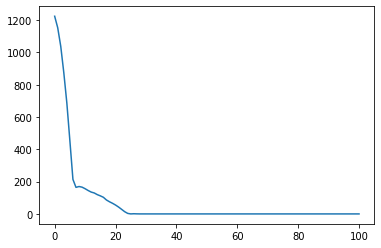

In [263]:
plt.plot(loss_history)

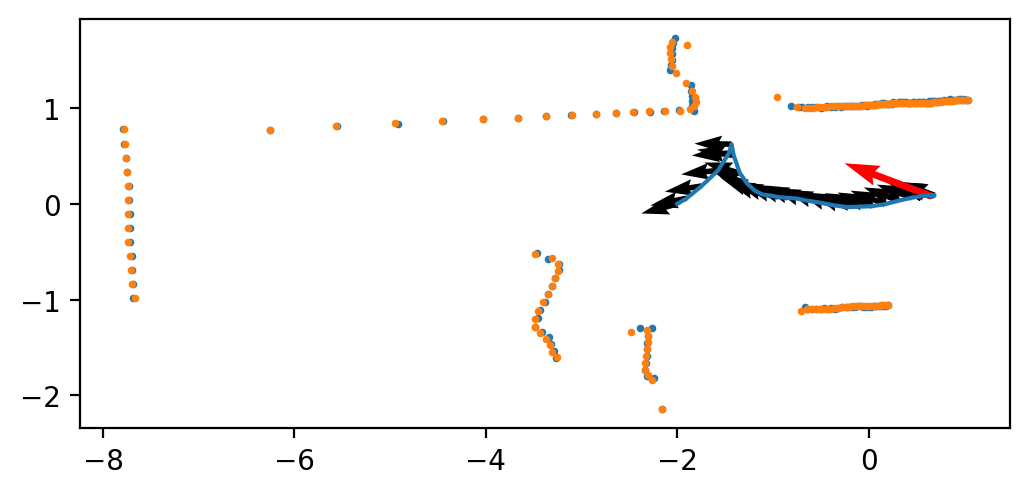

In [264]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plot_positions(position_history)
plot_position(laser_data.odometry_position.as_vec())
plt.gca().set_aspect('equal')

# x - angle surface

In [229]:
# position_angles, position_xs = jnp.meshgrid(jnp.linspace(1, 6, 40), jnp.linspace(-6, 2, 40))
position_angles, position_xs = jnp.meshgrid(jnp.linspace(1, 6, 40), jnp.linspace(-4, 4, 40))
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
# position = jnp.array(position_history[-1].as_vec())
losses = []
# direction_angle = 3 * np.pi / 4
# direction_angle = np.pi / 2
direction_angle = np.pi / 2
for angle, x in tqdm.tqdm(zip(position_angles.reshape(-1), position_xs.reshape(-1))):
    x_new = x * np.cos(direction_angle) + position[0]
    y_new = x * np.sin(direction_angle) + position[1]
    rotated_position = jnp.array([x_new, y_new, angle])
#     rotated_position = jnp.array([position[0], x, angle])
    loss = loss_function_without_normalization(variables, rotated_position, depths, angles, uniform, config)
    losses.append(loss)
losses = np.array(losses).reshape(position_angles.shape)

1600it [00:06, 249.34it/s]


In [230]:
optimization_trajectory = jnp.stack([
    jnp.array(Position2.from_array(position_history).rotation),
    jnp.array(Position2.from_array(position_history).y - position[1]),
    jnp.array(loss_history)
], axis=1)

In [231]:
import plotly.graph_objects as go

import pandas as pd
fig = go.Figure(data=[
    go.Surface(z=losses, x=position_angles, y=position_xs),
    go.Scatter3d(z=optimization_trajectory[:, 2], x=optimization_trajectory[:, 0], y=optimization_trajectory[:, 1])
])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

# lie Grdoup

In [265]:
from jaxlie import SE2, MatrixLieGroup


@jax.jit
def transform_points_lie(points, position, epsilon):
    return jax.vmap((SE2.exp(epsilon) @ position).apply)(points)

@functools.partial(jax.jit, static_argnums=5)
def predict_depths_lie(variables, epsilon, position: MatrixLieGroup, angles, uniform, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles, jnp.zeros((angles.shape[0], config.bins_count + 1)))
    points = transform_points_lie(points.reshape(-1, 2), position, epsilon)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    return predicted_depths

@functools.partial(jax.jit, static_argnums=6)
def lie_loss_function_without_normalization(variables, epsilon, position: MatrixLieGroup, 
                                            truth_depths, angles, uniform, config):
    predicted_depths = predict_depths_lie(variables, epsilon, position, angles, uniform, config)
    return jnp.sum(((truth_depths - predicted_depths) ** 2))

In [266]:
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
lie_position = SE2.from_xy_theta(0, 0, 0)
predict_depths_lie(variables, np.zeros(3), lie_position, angles, uniform, config);

In [273]:
jacobian_function = jax.jacfwd(functools.partial(predict_depths_lie, config=config), argnums=1)
position_grad_function = jax.grad(functools.partial(loss_function_without_normalization, config=config), argnums=1)
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))

# optimized_position = jnp.array([-3, 1., 2.77])
# optimized_position = jnp.array([0.656, 0.0812, 2])
# optimized_position = jnp.array([0.6, 0.08, 3.4])
# optimized_position = jnp.array([-2, 0., 3.3])
# optimized_position = jnp.array([0, -1, 2.7])
optimized_position = jnp.array(laser_data_list[7].odometry_position.as_vec())
# optimized_position = jnp.array(laser_data_list[3].odometry_position.as_vec())
print(optimized_position)

loss_history = [loss_function_without_normalization(variables, optimized_position, depths, angles, uniform, config)]
position_history = [Position2.from_vec(np.array(optimized_position))]
old_hessian = jnp.diag(jnp.array([2000, 2000, 200]))
old_grad = jnp.zeros(3)
for i in tqdm.tqdm(range(iterations)):
    lie_position = SE2.from_xy_theta(optimized_position[0], optimized_position[1], optimized_position[2])
    jacobian = jacobian_function(variables, jnp.array([0., 0, 0]), lie_position, angles, uniform)
    multiplicator = jnp.array([1, 1, 1])
    jacobian = jacobian * multiplicator
    jacobian_norm = jnp.linalg.norm(jacobian, axis=1)
    cliped_norm = jnp.clip(jacobian_norm, 0, 30)
    jacobian = jacobian / jacobian_norm[:, None] * cliped_norm[:, None]
    predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
    grad = 2 * jnp.sum(jacobian * (predicted_depths - depths)[:, None], axis=0)
    hessian = 2 * jacobian.T @ jacobian  + jnp.diag(jnp.array([20, 20, 2]))
    beta1 = 0.7
    beta2 = 0.4
    grad_noise = jax.random.normal(jax.random.PRNGKey(i), (3,)) * 10
#     grad = grad + grad_noise
    hessian = beta1 * old_hessian + (1 - beta1) * hessian
    grad = beta2 * old_grad + (1 - beta2) * grad
    old_grad = grad
    old_hessian = hessian
    delta = -(jnp.linalg.inv(hessian) @ (grad * multiplicator)) * multiplicator
#     delta_noise = jax.random.normal(jax.random.PRNGKey(i), (3,)) * np.exp(-i * 0.1) * jnp.array([0, 0, 0.5])
#     delta = delta + delta_noise
    if i == 0:
        np.set_printoptions(precision=5, suppress=True)
        print("Zero iteration")
        print("Hessian")
        print(jnp.linalg.inv(hessian), 4)
        print("grad")
        print(grad)
        print("delta")
        print(delta)
    lie_position = SE2.exp(delta) @ lie_position
    optimized_position = np.array([
        float(lie_position.translation()[0]),
        float(lie_position.translation()[1]), 
        float(lie_position.rotation().as_radians())])
    loss = lie_loss_function_without_normalization(variables, np.zeros(3), lie_position, 
                                                   depths, angles, uniform, config)
    loss_history.append(loss)
    position_history.append(Position2.from_vec(np.array(optimized_position)))
print(loss_history[-1])
print("Optimized position:", optimized_position)
print(laser_data.odometry_position.as_vec())
print(hessian)
print(grad)
print(delta)

[0.68539 0.11297 2.27307]


  8%|███▍                                       | 8/100 [00:00<00:01, 76.56it/s]

Zero iteration
Hessian
[[ 0.0006   0.      -0.     ]
 [ 0.       0.0006   0.00018]
 [-0.       0.00018  0.00028]] 4
grad
[132.89975 358.81958 110.76698]
delta
[-0.07992 -0.23564 -0.09581]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 82.35it/s]

529.0884
Optimized position: [ 0.35422 -0.86081  1.99506]
[0.65616 0.08127 2.77968]
[[ 2190.6575 -2095.3137  -305.3683]
 [-2095.3137 10705.366    849.7129]
 [ -305.3683   849.7129  8679.682 ]]
[-1.21649 -1.94877 -1.27021]
[0.00091 0.00035 0.00014]


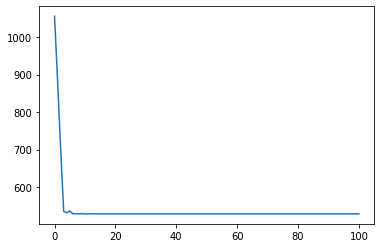

In [274]:
plt.plot(loss_history)

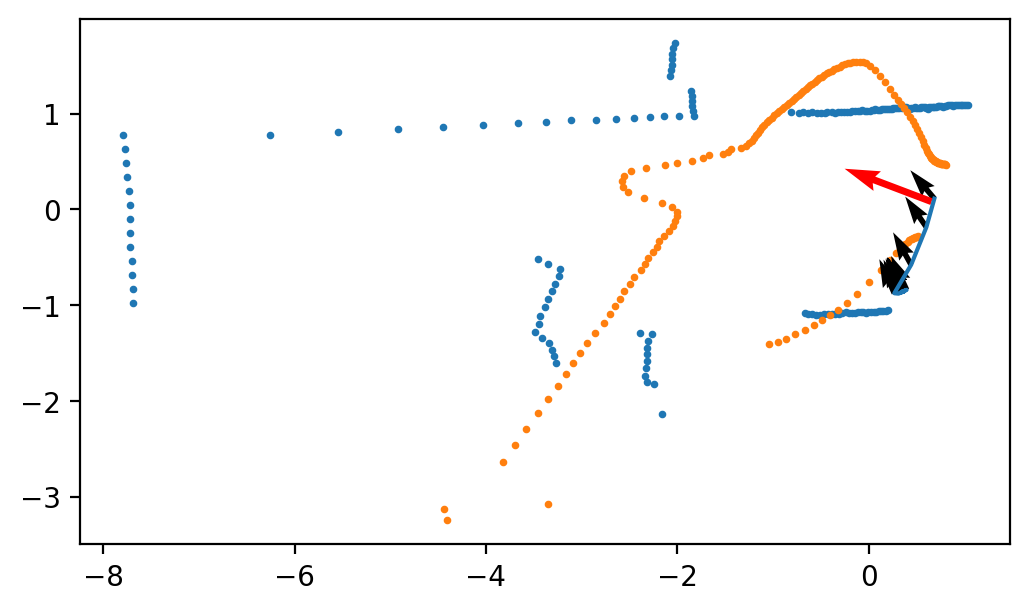

In [275]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plot_positions(position_history)
plot_position(laser_data.odometry_position.as_vec())
plt.gca().set_aspect('equal')